In [1]:
%cd ..
%load_ext nb_black

/home/hardianlawi/attention-lstm-sentiment-analysis


<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from src.preprocess import Preprocessor
from src.data import get_data
from src.models import get_model

import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(2020)

%matplotlib inline

plt.style.use("seaborn")
plt.rcParams["legend.frameon"] = True
sns.set_style("whitegrid", {"grid.linestyle": "--"})

(str_X_train, y_train), (str_X_val, y_val), (str_X_test, y_test) = get_data()

print("Train size:", len(str_X_train))
print("Val size:", len(str_X_val))
print("Test size:", len(str_X_test))

Train size: 23750
Val size: 1250
Test size: 25000


<IPython.core.display.Javascript object>

In [3]:
sentence_lens = list(
    map(lambda x: len(x.split()), str_X_train + str_X_val + str_X_test)
)
print("Maximum review length: {}".format(max(sentence_lens)))
print("Minimum review length: {}".format(min(sentence_lens)))

Maximum review length: 2470
Minimum review length: 4


<IPython.core.display.Javascript object>

In [4]:
max_words = 500
vocab_size = 5000

preprocessor = Preprocessor(maxlen=max_words, vocab_size=vocab_size, oov_token="<OOV>")
preprocessor.fit_on_texts(str_X_train + str_X_val + str_X_test)

X_train = preprocessor.transform(str_X_train)
X_val = preprocessor.transform(str_X_val)
X_test = preprocessor.transform(str_X_test)

<IPython.core.display.Javascript object>

In [5]:
emb_size = 32
batch_size = 64
epochs = 3

model, model_attention = get_model(
    "attention",
    max_words,
    vocab_size,
    emb_size,
    attention_hs=16,
    return_attn_weights=True,
)
model.summary(line_length=200)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", scores[1])

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_1 (InputLayer)                                                                      [(None, 500)]                                                                   0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
embedding (Embedding)                                                                     (None, 500, 32)                                                                 160000     

<IPython.core.display.Javascript object>

In [6]:
samples = [
    "The best film of the year to date, ambitious in conception and extraordinary in execution, has arrived."
]
sample_seqs = preprocessor.transform(samples)

<IPython.core.display.Javascript object>

In [7]:
attn_weights = model_attention(sample_seqs).numpy().squeeze(axis=-1)
attn_weights.shape

(1, 500)

<IPython.core.display.Javascript object>

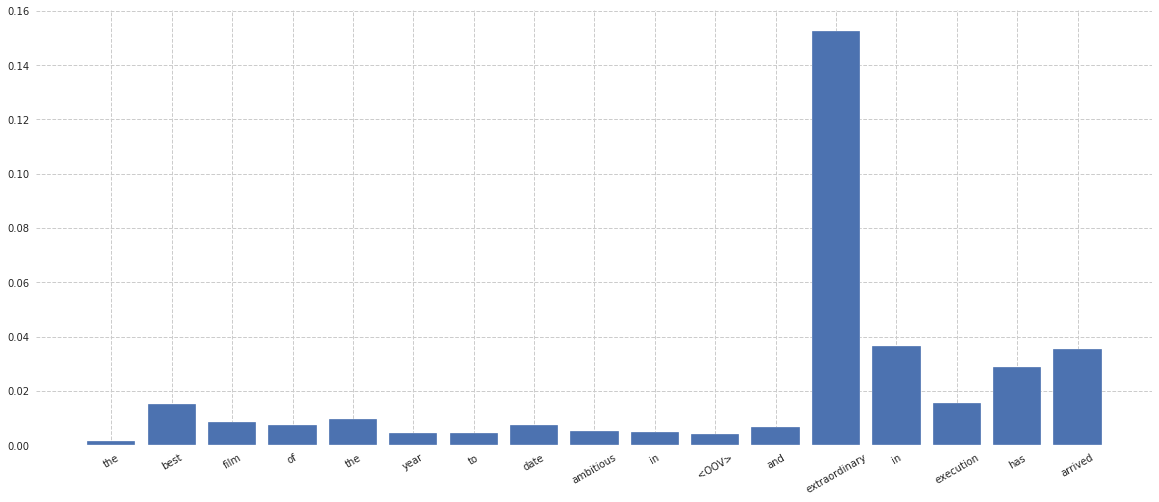

<IPython.core.display.Javascript object>

In [8]:
def plot_attention(attention, tokens):
    weights = []
    sentence = []
    for token, attention in zip(tokens, attention):
        if token != 0:
            sentence.append(preprocessor._tokenizer.index_word[token])
            weights.append(attention)

    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(range(len(sentence)), weights)
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, rotation=30)


plot_attention(attn_weights[0], sample_seqs[0])
plt.show()

We can see that the learned attention weights are putting a lot of weights on the words like *best* or *extraordinary in execution, has arrived* which shows how it is focusing on the words that generate the positive sentiment.